In [1]:
!pip install pandas 
!pip install numpy
!pip install matplotlib
!pip install tqdm
!pip install seaborn
!pip install tensorflow
!pip install keras

In [1]:
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
import urllib.request
import zipfile
import os
from tqdm import tqdm
import copy

In [2]:
# Create documents dataframe
dp_docs = [file for file in os.listdir('dependency_treebank/') if file.endswith('.dp')]
dataframes = []

for file in tqdm(dp_docs):
    with open('dependency_treebank/' + file, 'r') as f:
        lines = f.readlines()
        data = [line.split('\t') for line in lines]
        df = pd.DataFrame(data, columns=['word', 'pos', 'head'])
        # drop the last column
        df = df.iloc[:, :-1]
        dataframes.append(df)

df = pd.DataFrame({'Dataframes': dataframes})
print(df.head(5))
print(df['Dataframes'][0][0:5])
print(df.shape)

100%|██████████| 199/199 [00:00<00:00, 1097.20it/s]

                                          Dataframes
0              word   pos
0         Pierre   NNP
...
1              word  pos
0        Rudolph  NNP
1 ...
2           word   pos
0           A    DT
1     ...
3               word  pos
0          Yields  NNS
...
4                 word   pos
0              J.P. ...
     word  pos
0  Pierre  NNP
1  Vinken  NNP
2       ,    ,
3      61   CD
4   years  NNS
(199, 1)


In [3]:
# Split the dataframes into train, validation and test sets
train = df['Dataframes'][0:100]
val = df['Dataframes'][100:150]
test = df['Dataframes'][150:200]

print(train.shape)
print(val.shape)
print(test.shape)

(100,)
(50,)
(49,)


In [4]:
# Text preprocessing
def to_lower_case(df, docs):
    for i in range(docs, len(df)):
        df[i]['word'] = df[i]['word'].str.lower()

to_lower_case(train, 0)
to_lower_case(val, 100)
to_lower_case(test, 150)
print(train[0][0:5])

     word  pos
0  pierre  NNP
1  vinken  NNP
2       ,    ,
3      61   CD
4   years  NNS


In [23]:
# Text preprocessing: from each doc remove newlines and empty lines
def remove_newlines(df, docs):
    for i in range(docs, len(df)):
        df[i] = df[i][df[i]['word'] != '\n']
        df[i] = df[i][df[i]['word'] != '']

remove_newlines(train, 0)
remove_newlines(val, 100)
remove_newlines(test, 150)
print(train[0])
print(len(train[0]))

            word  pos
0         pierre  NNP
1         vinken  NNP
2              ,    ,
3             61   CD
4          years  NNS
5            old   JJ
6              ,    ,
7           will   MD
8           join   VB
9            the   DT
10         board   NN
11            as   IN
12             a   DT
13  nonexecutive   JJ
14      director   NN
15          nov.  NNP
16            29   CD
17             .    .
19           mr.  NNP
20        vinken  NNP
21            is  VBZ
22      chairman   NN
23            of   IN
24      elsevier  NNP
25          n.v.  NNP
26             ,    ,
27           the   DT
28         dutch  NNP
29    publishing  VBG
30         group   NN
31             .    .
31


In [51]:
# Create new dataframe that contains the single sentences
def create_sentences(df, docs):
    sentences = []
    chunks = []
    for i in range(docs, len(df)):
        for element in df[i]['word']:
            if element != '.' and element != '!' and element != '?':
                chunks.append(element)
            else:
                chunks.append(element)
                sentences.append(chunks)
                chunks = []
    return sentences

# Create sentences for train, val and test
train_sentences = create_sentences(train, 0)
print(train_sentences)
print(len(train_sentences))

[['pierre', 'vinken', ',', '61', 'years', 'old', ',', 'will', 'join', 'the', 'board', 'as', 'a', 'nonexecutive', 'director', 'nov.', '29', '.'], ['mr.', 'vinken', 'is', 'chairman', 'of', 'elsevier', 'n.v.', ',', 'the', 'dutch', 'publishing', 'group', '.'], ['rudolph', 'agnew', ',', '55', 'years', 'old', 'and', 'former', 'chairman', 'of', 'consolidated', 'gold', 'fields', 'plc', ',', 'was', 'named', 'a', 'nonexecutive', 'director', 'of', 'this', 'british', 'industrial', 'conglomerate', '.'], ['a', 'form', 'of', 'asbestos', 'once', 'used', 'to', 'make', 'kent', 'cigarette', 'filters', 'has', 'caused', 'a', 'high', 'percentage', 'of', 'cancer', 'deaths', 'among', 'a', 'group', 'of', 'workers', 'exposed', 'to', 'it', 'more', 'than', '30', 'years', 'ago', ',', 'researchers', 'reported', '.'], ['the', 'asbestos', 'fiber', ',', 'crocidolite', ',', 'is', 'unusually', 'resilient', 'once', 'it', 'enters', 'the', 'lungs', ',', 'with', 'even', 'brief', 'exposures', 'to', 'it', 'causing', 'symptoms

In [52]:
def create_tag_sentences(df, docs):
    tag_sentences = []
    chunks = []
    for i in range(docs, len(df)):
        for element in df[i]['pos']:
            if element != '.' and element != '!' and element != '?':
                chunks.append(element)
            else:
                chunks.append(element)
                tag_sentences.append(chunks)
                chunks = []
    return tag_sentences

# Create tag sentences for train, val and test
train_tag_sentences = create_tag_sentences(train, 0)
print(train_tag_sentences)
print(len(train_tag_sentences))

[['NNP', 'NNP', ',', 'CD', 'NNS', 'JJ', ',', 'MD', 'VB', 'DT', 'NN', 'IN', 'DT', 'JJ', 'NN', 'NNP', 'CD', '.'], ['NNP', 'NNP', 'VBZ', 'NN', 'IN', 'NNP', 'NNP', ',', 'DT', 'NNP', 'VBG', 'NN', '.'], ['NNP', 'NNP', ',', 'CD', 'NNS', 'JJ', 'CC', 'JJ', 'NN', 'IN', 'NNP', 'NNP', 'NNP', 'NNP', ',', 'VBD', 'VBN', 'DT', 'JJ', 'NN', 'IN', 'DT', 'JJ', 'JJ', 'NN', '.'], ['DT', 'NN', 'IN', 'NN', 'RB', 'VBN', 'TO', 'VB', 'NNP', 'NN', 'NNS', 'VBZ', 'VBN', 'DT', 'JJ', 'NN', 'IN', 'NN', 'NNS', 'IN', 'DT', 'NN', 'IN', 'NNS', 'VBN', 'TO', 'PRP', 'RBR', 'IN', 'CD', 'NNS', 'IN', ',', 'NNS', 'VBD', '.'], ['DT', 'NN', 'NN', ',', 'NN', ',', 'VBZ', 'RB', 'JJ', 'IN', 'PRP', 'VBZ', 'DT', 'NNS', ',', 'IN', 'RB', 'JJ', 'NNS', 'TO', 'PRP', 'VBG', 'NNS', 'WDT', 'VBP', 'RP', 'NNS', 'JJ', ',', 'NNS', 'VBD', '.'], ['NNP', 'NNP', ',', 'DT', 'NN', 'IN', 'JJ', 'JJ', 'NNP', 'NNP', 'WDT', 'VBZ', 'NNP', 'NNS', ',', 'VBD', 'VBG', 'NN', 'IN', 'PRP$', 'NN', 'NN', 'NNS', 'IN', 'CD', '.'], ['IN', 'JJ', 'NNS', 'VBD', 'VBN', 'RBR',

In [58]:
print(len(train_sentences[0]))
print(len(train_tag_sentences[0]))

18
18


In [59]:
# Encode train sentences and tags
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences

# Encode train sentences
sentence_tokenizer = Tokenizer()
sentence_tokenizer.fit_on_texts(train_sentences)
encoded_train_sentences = sentence_tokenizer.texts_to_sequences(train_sentences)

print(encoded_train_sentences[0])

[3426, 2308, 1, 1743, 64, 342, 1, 40, 1370, 2, 191, 23, 6, 1119, 269, 707, 2309, 3]


In [60]:
tag_tokenizer = Tokenizer()
tag_tokenizer.fit_on_texts(train_tag_sentences)
encoded_train_tags = tag_tokenizer.texts_to_sequences(train_tag_sentences)

print(encoded_train_tags[0])

[2, 2, 7, 11, 5, 6, 7, 20, 12, 4, 1, 3, 4, 6, 1, 2, 11, 8]


250


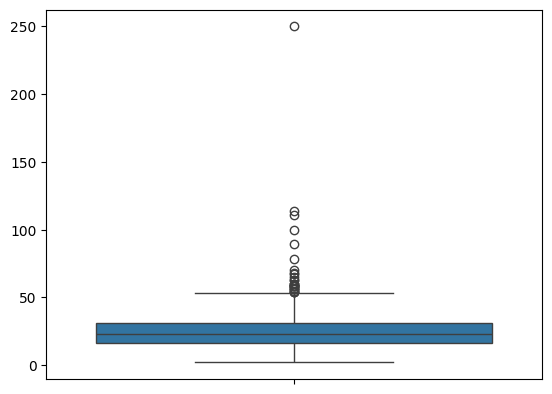

In [61]:
# check length of longest sentence 
lengths = [len(sentence) for sentence in encoded_train_sentences]
print(max(lengths))
sns.boxplot(lengths)
plt.show()

In [64]:
# Pad each sequence to MAX_SEQ_LENGTH using KERAS' pad_sequences() function. 
# Sentences longer than MAX_SEQ_LENGTH are truncated.
# Sentences shorter than MAX_SEQ_LENGTH are padded with zeroes.

# Truncation and padding can either be 'pre' or 'post'. 
# For padding we are using 'pre' padding type, that is, add zeroes on the left side.
# For truncation, we are using 'post', that is, truncate a sentence from right side.

MAX_SEQ_LENGTH = 100
X_train = pad_sequences(encoded_train_sentences, maxlen=MAX_SEQ_LENGTH, padding='pre', truncating='post')
print(X_train[0])
Y_train = pad_sequences(encoded_train_tags, maxlen=MAX_SEQ_LENGTH, padding='pre', truncating='post')
print(Y_train[0])
print(len(X_train[0]))
print(len(Y_train[0]))

[   0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0 3426 2308
    1 1743   64  342    1   40 1370    2  191   23    6 1119  269  707
 2309    3]
[ 0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  2  2  7 11  5  6  7 20 12  4  1  3  4  6
  1  2 11  8]
100
100


In [65]:
import gensim
import gensim.downloader as gloader

def load_embedding_model(embedding_dimension: int = 50) -> gensim.models.keyedvectors.KeyedVectors:
    download_path = ""
    download_path = "glove-wiki-gigaword-{}".format(embedding_dimension)
        
    try:
        emb_model = gloader.load(download_path)
    except ValueError as e:
        print("Invalid embedding model name! Check the embedding dimension:")
        print("Glove: 50, 100, 200, 300")
        raise e

    return emb_model

In [66]:
# Glove -> 50, 100, 200, 300
embedding_model = load_embedding_model(embedding_dimension=50)

In [74]:
vocab_size = len(sentence_tokenizer.word_index) + 1
print(vocab_size)
embedding_matrix = np.zeros((vocab_size, 50))

word2id = sentence_tokenizer.word_index

for word, i in tqdm(word2id.items()):
    try:
        embedding_matrix[i, :] = embedding_model[word]
    except KeyError:
        pass

print(embedding_matrix.shape)
print(embedding_matrix[word2id['the']])

7405


100%|██████████| 7404/7404 [00:00<00:00, 264368.94it/s]

(7405, 50)
[ 4.18000013e-01  2.49679998e-01 -4.12420005e-01  1.21699996e-01
  3.45270008e-01 -4.44569997e-02 -4.96879995e-01 -1.78619996e-01
 -6.60229998e-04 -6.56599998e-01  2.78430015e-01 -1.47670001e-01
 -5.56770027e-01  1.46579996e-01 -9.50950012e-03  1.16579998e-02
  1.02040000e-01 -1.27920002e-01 -8.44299972e-01 -1.21809997e-01
 -1.68009996e-02 -3.32789987e-01 -1.55200005e-01 -2.31309995e-01
 -1.91809997e-01 -1.88230002e+00 -7.67459989e-01  9.90509987e-02
 -4.21249986e-01 -1.95260003e-01  4.00710011e+00 -1.85939997e-01
 -5.22870004e-01 -3.16810012e-01  5.92130003e-04  7.44489999e-03
  1.77780002e-01 -1.58969998e-01  1.20409997e-02 -5.42230010e-02
 -2.98709989e-01 -1.57490000e-01 -3.47579986e-01 -4.56370004e-02
 -4.42510009e-01  1.87849998e-01  2.78489990e-03 -1.84110001e-01
 -1.15139998e-01 -7.85809994e-01]


In [75]:
# For tags use one-hot encoding
from keras.utils import to_categorical

Y_train = to_categorical(Y_train)
print(Y_train.shape)
print(Y_train[0])

(1959, 100, 46)
[[1. 0. 0. ... 0. 0. 0.]
 [1. 0. 0. ... 0. 0. 0.]
 [1. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 1. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
